# Skin lesion classification

# Giovanni BENEDETTI DA ROSA

**Deadline**: Upload this notebook (rename it as 'TP-SVM-YOUR-SURNAME.ipynb') to Ecampus/Moodle before the deadline. 
Complete the code where you see XXXXXXXXXXXXXXXXX (mandatory for everybody)

**Context**
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become melanoma, one of the deadliest skin cancer. Its incidence has been increasing during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for melanoma detection have been proposed in the last years (non-invasive computer-aided diagnosis (CAD) ).


**Goal**
The goal of this practical session is to classify images of skin lesions as either benign or melanoma using machine learning algorithms. In order to do that, you will have at your disposal a set of 30 features already extracted from 600 dermoscopic images (both normal skin lesions and melanoma from the ISIC database - https://isic-archive.com/). These features characterize the Asymmetry, the Border irregularity, the Colour and the Dimension of the lesion (the so-called ABCD rule). 

The features are:
- shape asimmetry (f0 and f1)
- difference in colors between center and periphery of the image (f2, f3, f4, f27, f28, f29)
- geometry (f5, f6, f7)
- other features related to eccentricity,entropy, mean, standard deviation and maximum value of each channel in RGB and HSV (f8,...,f24)
- asimmetry of color intensity (f25, f26)

Features are computed using *manually checked segmentations* and following *Ganster et al. 'Automated melanoma recognition', IEEE TMI, 2001* and *Zortea et al. 'Performance of a dermoscopy-based computer vision system for the diagnosis of pigmented skin lesions compared with visual evaluation by experienced dermatologists', Artificial Intelligence in Medicine, 2014*.

First load all necessary packages

In [80]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.linear_model import Perceptron
from sklearn.decomposition import PCA

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Code from scikit-learn
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


from sklearn.pipeline import make_pipeline

Then load the data from my Google Drive

In [81]:
'''from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='18hrQVGBCfW7SKTnzmWUONo8iowBsi1DL',
dest_path='./data/features.csv')
gdd.download_file_from_google_drive(file_id='1iQZdUiuK_FwZ7mik7LB3eN_H_IUc5l7b',
dest_path='./data/im/nevus-seg.jpg')
gdd.download_file_from_google_drive(file_id='1_TeYzLLDoKbPX4xXAOAM_mQiT2nLHgvp',
dest_path='./data/im/nevus.jpg')
gdd.download_file_from_google_drive(file_id='1B2Ol92mBcHN6ah3bpoucBbBbHkPMGC8D',
dest_path='./data/im/melanoma-seg.jpg')
gdd.download_file_from_google_drive(file_id='1yZ46UzGhwO7g5T8397JpewBl6UqgRo5J',
dest_path='./data/im/melanoma.jpg')'''

"from google_drive_downloader import GoogleDriveDownloader as gdd\ngdd.download_file_from_google_drive(file_id='18hrQVGBCfW7SKTnzmWUONo8iowBsi1DL',\ndest_path='./data/features.csv')\ngdd.download_file_from_google_drive(file_id='1iQZdUiuK_FwZ7mik7LB3eN_H_IUc5l7b',\ndest_path='./data/im/nevus-seg.jpg')\ngdd.download_file_from_google_drive(file_id='1_TeYzLLDoKbPX4xXAOAM_mQiT2nLHgvp',\ndest_path='./data/im/nevus.jpg')\ngdd.download_file_from_google_drive(file_id='1B2Ol92mBcHN6ah3bpoucBbBbHkPMGC8D',\ndest_path='./data/im/melanoma-seg.jpg')\ngdd.download_file_from_google_drive(file_id='1yZ46UzGhwO7g5T8397JpewBl6UqgRo5J',\ndest_path='./data/im/melanoma.jpg')"

Or from yout local computer. Please download the 'data' folder in the same folder as your notebook and do not modifiy it.

Then read the data 

In [82]:
## Read data
Working_directory="./data/" 
df = pd.read_csv(Working_directory + 'features.csv') # reading data
y = df['Malignant'].values # 1 for Melanoma and 0 for healthy
class_names = ["healthy","melanoma"]
X = df.iloc[:,3:33].values # Features
N,M=X.shape
print('Number of images: {0}; Number of features per image: {1}'.format(N,M))
print('Number of healthy nevus: {0}; Number of melanoma: {1}'.format(N-np.sum(y), np.sum(y)))


Number of images: 600; Number of features per image: 30
Number of healthy nevus: 485; Number of melanoma: 115


Two examples of healthy nevus and melanoma


Text(0.5, 1.0, 'Segmented melanoma')

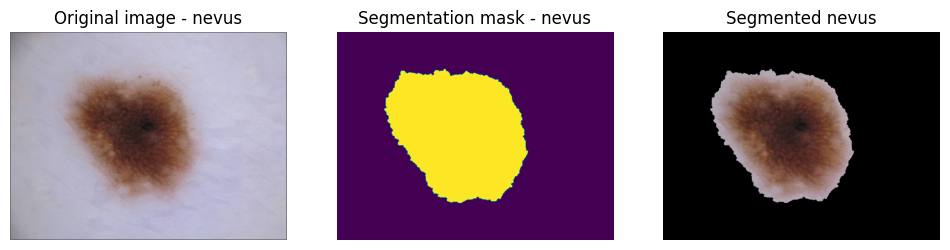

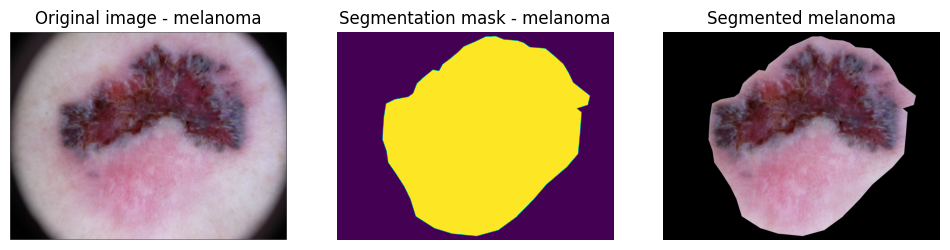

In [83]:
## Plot two examples of nevus and melanoma
print('Two examples of healthy nevus and melanoma')
nevus = imread(Working_directory + 'im/nevus.jpg')
nevus_Segmentation = imread(Working_directory + 'im/nevus-seg.jpg') 
nevus_Segmentation_boolean = (nevus_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
nevus_Segmentation_3D = np.expand_dims(nevus_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
nevus_mul_mask = (nevus_Segmentation_3D*nevus) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(nevus)
grid[0].axis('off')
grid[0].set_title('Original image - nevus')
grid[1].imshow(nevus_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - nevus")
grid[2].imshow(nevus_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented nevus")

###

melanoma = imread(Working_directory + 'im/melanoma.jpg')
melanoma_Segmentation = imread(Working_directory + 'im/melanoma-seg.jpg') 
melanoma_Segmentation_boolean = (melanoma_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
melanoma_Segmentation_3D = np.expand_dims(melanoma_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
melanoma_mul_mask = (melanoma_Segmentation_3D*melanoma) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(melanoma)
grid[0].axis('off')
grid[0].set_title('Original image - melanoma')
grid[1].imshow(melanoma_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - melanoma")
grid[2].imshow(melanoma_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented melanoma")


Now, as in the previous practical session you should shuffle the data randomly

In [84]:
# Shuffle data randomly.
order=np.arange(0,N)
np.random.shuffle(order)

Xp=X[order[:]]
yp=y[order[:]]

We should now test the discriminative power of our features. Fist, let divide the entire data-set into training and test set using the `stratify` option. This will preserve the original proportion between nevus and melanoma also in the training and test set. You can check that from the plot.

Text(0, 0.5, 'Proportion')

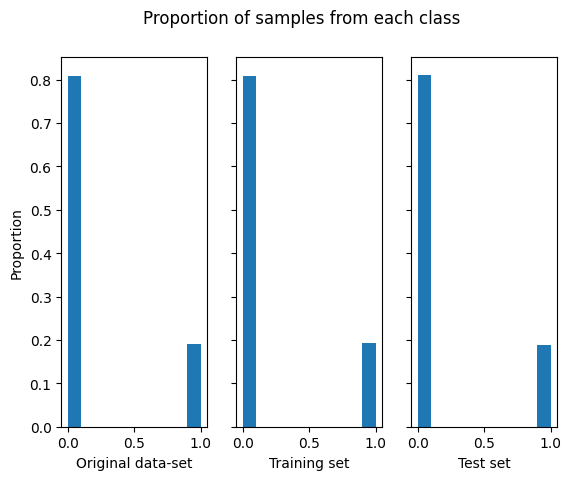

In [85]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(Xp, yp, test_size=0.3, random_state=42,stratify=yp)

fig, axs = plt.subplots(1, 3, sharey=True)
fig.suptitle('Proportion of samples from each class')
axs[0].hist(yp,weights=np.ones_like(yp)/len(yp))
axs[0].set_xlabel('Original data-set')
axs[1].hist(y_train,weights=np.ones_like(y_train)/len(y_train))
axs[1].set_xlabel('Training set')
axs[2].hist(y_test,weights=np.ones_like(y_test)/len(y_test))
axs[2].set_xlabel('Test set')
axs[0].set_ylabel('Proportion')

As we have already seen, it might be very important to scale the data such that each feature has, for instance, average equal to 0 and unit variance. Which is the right way of doing it when having a training and a test set in your opinion ? Should you use together both training and test set ? (For simplicity's sake, we will restrict here to scaling all features).

**Answer:** To ensure unbiased transformation, we must first standardize the training dataset using the standard scaler, computing its mean and variance. These parameters are then utilized to transform each dataset independently. Otherwise, without this preprocessing step, the test dataset might inadvertently impact the training phase, compromising its "unseen" status.

In [86]:
# Scale data (each feature will have average equal to 0 and unit variance)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)


Now, use two simple classification algorithms, for instance LDA and QDA, and look at the confusion matrices. 

**Question**: Comment the results. 

**Answer:**

As we have seen before, the data is imbalanced, with class 1 (melanoma) being the minority class. These results suggest that the model performs well in identifying instances of the majority class (class 0) but struggles with the minority class (class 1).

The F1-score is the harmonic mean of precision and recall and provides a balance between the two metrics. For class 0, the F1-score is relatively high at 0.90, indicating a good balance between precision and recall. However, for class 1, the F1-score is much lower at 0.27, indicating a poorer balance between precision and recall. As we can see, the recall, true positive rate, for this class is 0.18, indicating that the model misses a substantial portion of the true positives for class 1.

 This can be checked by the FN(False Negatives) ratio which is really low. In practice, the main goal of this classification is to find melanoma lesions, so it's really bad to predict healthy when it's melanoma. Given that, by looking at the metrics of the confusion, we can see that both models (LDA and PCA) perform poorly in this problem.

Fitting LDA to training set
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       146
           1       0.57      0.24      0.33        34

    accuracy                           0.82       180
   macro avg       0.71      0.60      0.62       180
weighted avg       0.79      0.82      0.79       180

Normalized confusion matrix
[[0.95890411 0.04109589]
 [0.76470588 0.23529412]]


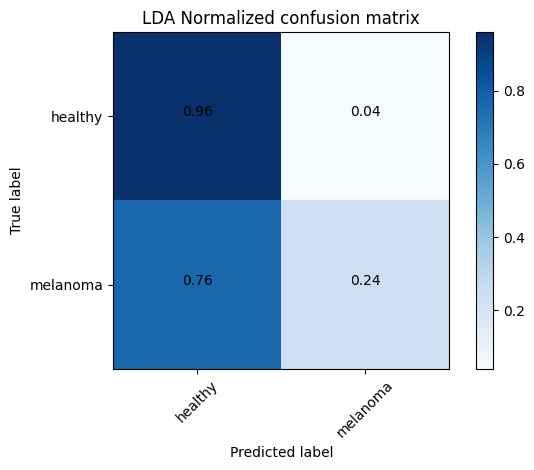

Fitting QDA to training set
              precision    recall  f1-score   support

           0       0.83      0.97      0.90       146
           1       0.55      0.18      0.27        34

    accuracy                           0.82       180
   macro avg       0.69      0.57      0.58       180
weighted avg       0.78      0.82      0.78       180

Normalized confusion matrix
[[0.96575342 0.03424658]
 [0.82352941 0.17647059]]


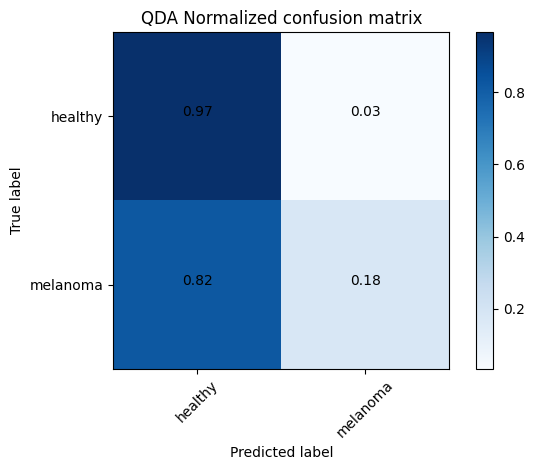

In [87]:
# Fitting LDA
print("Fitting LDA to training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scale, y_train)
y_pred = lda.predict(X_test_scale)
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='LDA Normalized confusion matrix')
plt.show()

# Fitting QDA
print("Fitting QDA to training set")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scale, y_train)
y_pred = qda.predict(X_test_scale)
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                     title='QDA Normalized confusion matrix')
plt.show()

The results you obtained are based on a precise subdivision of your data into training and test. This can thus bias your results. Which technique could you use instead ? Test it  with LDA, QDA and K-NN.

**Answer:** We could use Cross-Validation.

In [88]:
# Fitting LDA
print("Fitting LDA")
lda = LinearDiscriminantAnalysis()
lda_score = cross_val_score(lda,X=X_train,y= y_train,cv=5)
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
qda = QuadraticDiscriminantAnalysis()
qda_score = cross_val_score(qda,X=X_train, y=y_train,cv=5)
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
neigh = KNeighborsClassifier(n_neighbors=3)
neigh_score = cross_val_score(neigh,X=X_train, y=y_train,cv=5)
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))

Fitting LDA
 Average and std CV score : 0.7952380952380953 +- 0.03140691894826883
Fitting QDA
 Average and std CV score : 0.7976190476190477 +- 0.022587697572631283
Fitting K-nearest neighbour
 Average and std CV score : 0.7428571428571429 +- 0.028769157079987083


---
When using K-NN, instead than fixing the number of nearest neighbours, we could also estimate the best value using Cross Validation. 

**Question** Do it and plot the confusion matrix. Do you notice anything strange ? Why in your opinion do you have this kind of result ?

---

**Answer** The result of KNN of finding the best hyperparameter remains really poor. This is probably still happening because of the imabaleced data.

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])
Best training Score: 0.8166666666666668
Best training params: {'kneighborsclassifier__n_neighbors': 8}
Normalized confusion matrix
[[0.97945205 0.02054795]
 [0.85294118 0.14705882]]


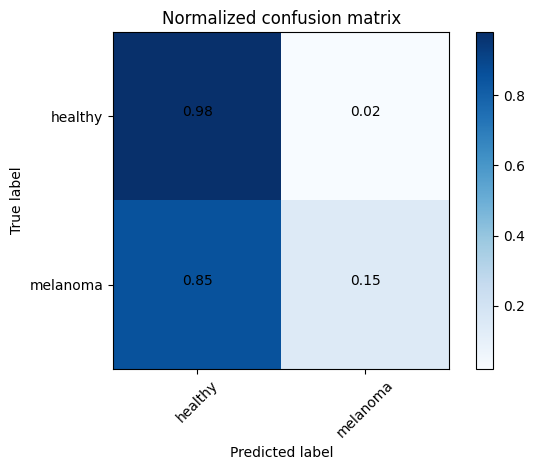

In [89]:
# Looking for the best hyperparameters
neigh = make_pipeline(StandardScaler(), KNeighborsClassifier())
# when using the pipeline, you can print the parameters of the estimator using print(neigh.get_params().keys())`
print(neigh.get_params().keys())
p_grid_KNN = {'kneighborsclassifier__n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
grid_KNN = GridSearchCV(estimator=neigh, param_grid=p_grid_KNN, scoring="accuracy", cv=5)
grid_KNN.fit(X_train, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In order to deal with this problem we have two possible solutions. 

**First**: Please look at this webpage (https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) and try MORE APPROPRIATE scoring functions than accuracy when looking for the best K value of K-NN (thus within the Cross Validation as before..).

**Answer:** We can check that using f1-score and the rate of FN is lowe than before.

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])


Best training Score: 0.3563930562191432
Best training params: {'kneighborsclassifier__n_neighbors': 5}
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       146
           1       0.65      0.38      0.48        34

    accuracy                           0.84       180
   macro avg       0.76      0.67      0.69       180
weighted avg       0.83      0.84      0.83       180

Normalized confusion matrix
[[0.95205479 0.04794521]
 [0.61764706 0.38235294]]


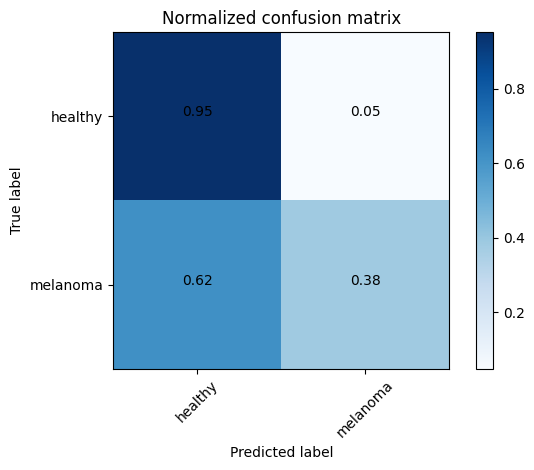

In [90]:
# Looking for the best hyperparameters
# Looking for the best hyperparameters
neigh = make_pipeline(StandardScaler(), KNeighborsClassifier())
# when using the pipeline, you can print the parameters of the estimator using print(neigh.get_params().keys())`
print(neigh.get_params().keys())
p_grid_KNN = {'kneighborsclassifier__n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
grid_KNN = GridSearchCV(estimator=neigh, param_grid=p_grid_KNN, scoring="f1", cv=5)
grid_KNN.fit(X_train, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])


Best training Score: 0.8166666666666668
Best training params: {'kneighborsclassifier__n_neighbors': 8}
              precision    recall  f1-score   support

           0       0.83      0.98      0.90       146
           1       0.62      0.15      0.24        34

    accuracy                           0.82       180
   macro avg       0.73      0.56      0.57       180
weighted avg       0.79      0.82      0.77       180

Normalized confusion matrix
[[0.97945205 0.02054795]
 [0.85294118 0.14705882]]


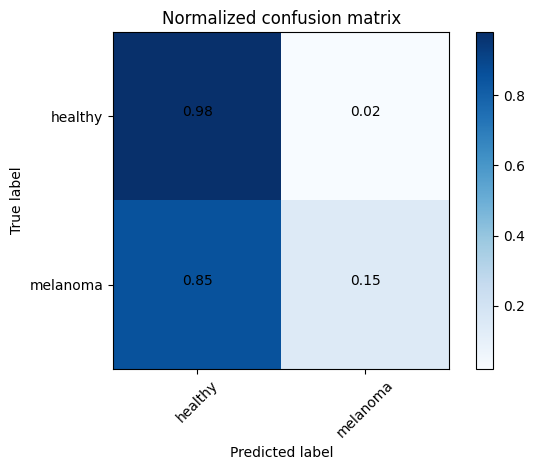

In [91]:
# Looking for the best hyperparameters
# Looking for the best hyperparameters
neigh = make_pipeline(StandardScaler(), KNeighborsClassifier())
# when using the pipeline, you can print the parameters of the estimator using print(neigh.get_params().keys())`
print(neigh.get_params().keys())
p_grid_KNN = {'kneighborsclassifier__n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
grid_KNN = GridSearchCV(estimator=neigh, param_grid=p_grid_KNN, scoring="accuracy", cv=5)
grid_KNN.fit(X_train, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


**Second**: when dealing with such a problem (the one you should find !) a possible solution would be to oversample a class (which one in your opinion ?) Please look at this web page for more information (https://imbalanced-learn.org/stable/over_sampling.html) and try at least the ADASYN over-sampling strategy (look at the following code...).

NB: if you want to use the naive random oversampling (i.e. randomly sampling with replacement) be careful not to have the same sample both in the training and validation (or test) set during cross-validation (or testing). This would be considered as a data-leakage. 

**Answer** The results are finally are a little bit better. The FN ratio has reduced even more and the other metrics did not have significant changes.

[(0, 339), (1, 356)]


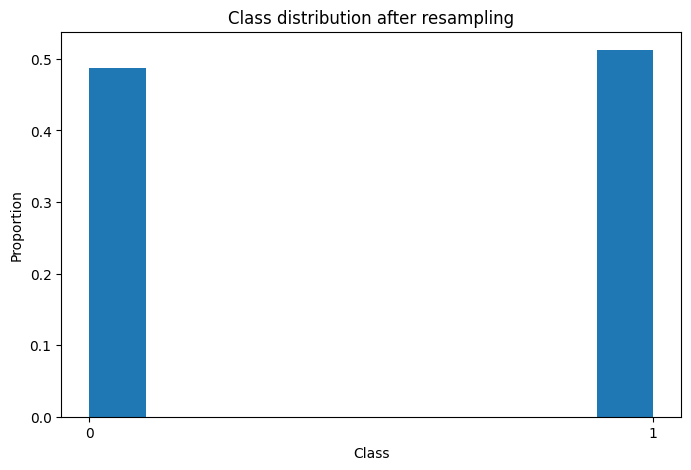

In [92]:
from imblearn.over_sampling import ADASYN
from collections import Counter
ros = ADASYN(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

# Class distribution after resampling
# Plot the histogram

fig, axs = plt.subplots(1, 1, figsize=(8, 5))

axs.hist(y_resampled, weights=np.ones_like(y_resampled)/len(y_resampled))
axs.set_title('Class distribution after resampling')
axs.set_xlabel('Class')
axs.set_ylabel('Proportion')
axs.set_xticks([0, 1])

# Show the plot
plt.show()

Let's look for the best K in KNN (as before using Cross validation) but this time on the new training set. 

**Question**: Are the results better ? Do they change now if you modify the scoring function ? Why ?

**Answer**:The results were  better mainly in classifying the melanoma lesions, in comparision to the original data. This can be ilustrated mainky by looking at the growing of FN ratio og the class 1.

The results change a little bit if we change the scoring function, as it was expected, once we are changing the way the metric to find the best hyperparameter.

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])
Best training Score: 0.8668927639552001
Best training params: {'kneighborsclassifier__n_neighbors': 1}
              precision    recall  f1-score   support

           0       0.89      0.71      0.79       146
           1       0.33      0.62      0.43        34

    accuracy                           0.69       180
   macro avg       0.61      0.66      0.61       180
weighted avg       0.78      0.69      0.72       180

Normalized confusion matrix
[[0.71232877 0.28767123]
 [0.38235294 0.61764706]]


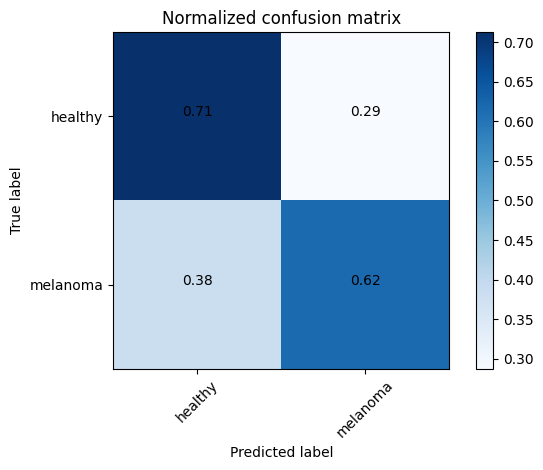

In [93]:
# Looking for the best hyperparameters
# Looking for the best hyperparameters
neigh = make_pipeline(StandardScaler(), KNeighborsClassifier())
# when using the pipeline, you can print the parameters of the estimator using print(neigh.get_params().keys())`
print(neigh.get_params().keys())
p_grid_KNN = {'kneighborsclassifier__n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
grid_KNN = GridSearchCV(estimator=neigh, param_grid=p_grid_KNN, scoring="f1", cv=5)
grid_KNN.fit(X_resampled, y_resampled)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])


Best training Score: 0.8503597122302159
Best training params: {'kneighborsclassifier__n_neighbors': 2}
              precision    recall  f1-score   support

           0       0.89      0.82      0.85       146
           1       0.43      0.59      0.49        34

    accuracy                           0.77       180
   macro avg       0.66      0.70      0.67       180
weighted avg       0.81      0.77      0.79       180

Normalized confusion matrix
[[0.81506849 0.18493151]
 [0.41176471 0.58823529]]


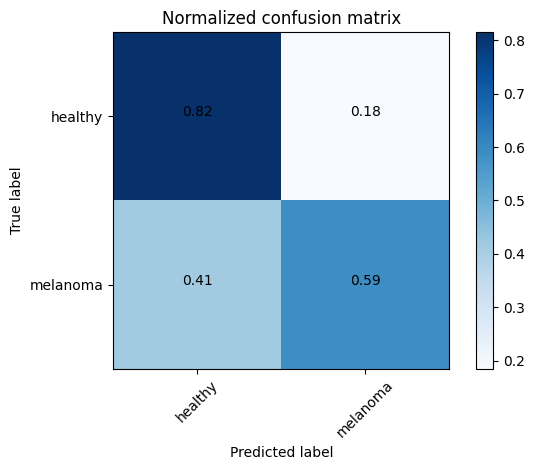

In [94]:
# Looking for the best hyperparameters
# Looking for the best hyperparameters
neigh = make_pipeline(StandardScaler(), KNeighborsClassifier())
# when using the pipeline, you can print the parameters of the estimator using print(neigh.get_params().keys())`
print(neigh.get_params().keys())
p_grid_KNN = {'kneighborsclassifier__n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
grid_KNN = GridSearchCV(estimator=neigh, param_grid=p_grid_KNN, scoring="accuracy", cv=5)
grid_KNN.fit(X_resampled, y_resampled)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


Let's use the techniques seen today: Perceptron and linear SVM. 

In [95]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline(StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,Xp, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_score'].mean(), Perc_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_score'].mean(), Perc_cv['test_score'].std() ))


# Fitting linear SVM on original data
print("Fitting Linear SVM")
Lsvm = make_pipeline(StandardScaler(), LinearSVC()) 
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_score'].mean(), Lsvm_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_score'].mean(), Lsvm_cv['test_score'].std() ))

Fitting Perceptron
 Average and std TRAIN CV accuracy : 0.7525000000000001 +- 0.04734990906948915
 Average and std TEST CV accuracy : 0.7350000000000001 +- 0.03590109871423001
Fitting Linear SVM


 Average and std TRAIN CV accuracy : 0.8420833333333333 +- 0.006095307849303225
 Average and std TEST CV accuracy : 0.8216666666666667 +- 0.01715938356831166


We can easily use different scoring functions within the cross validate function of scikit-learn. Check the code.

In [96]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline(StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,Xp, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))


# Fitting linear SVM on original data
print("Fitting Linear SVM")
Lsvm = make_pipeline(StandardScaler(), LinearSVC()) 
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))


Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.7525000000000001 +- 0.04734990906948915
 Average and std TEST CV accuracy : 0.7350000000000001 +- 0.03590109871423001
 Average and std TRAIN CV f1 : 0.381864800436229 +- 0.06618310384828516
 Average and std TEST CV f1 : 0.33954344305441075 +- 0.08751730157580681
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.8424999999999999 +- 0.006123724356957924
 Average and std TEST CV accuracy : 0.8183333333333334 +- 0.01699673171197594
 Average and std TRAIN CV f1 : 0.4124521012901054 +- 0.0306213378774074
 Average and std TEST CV f1 : 0.3406546489563567 +- 0.0395444508988001


**Question** Please do the same on the oversampled data and compare the results with the previous ones. Please note that here you should use the ‘make_pipeline‘ function of Imbalanced scikit-learn. You can look here:  [LINK](https://imbalanced-learn.org/stable/references/generated/imblearn.pipeline.make_pipeline.html)

**Answer:**

As expected,oversampling increases the representation of the minority class, potentially biasing the model towards it. As a result, while the model may perform well on the oversampled data this leads to a more balanced classification to both training and test sets, inceasing the F1 score and reducing a little bit the acuracy. This occurs because the model becomes more specialized on the minority class during training.


In [97]:
from imblearn.pipeline import make_pipeline as make_pipeline2 

# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline2(ADASYN(random_state=0),StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,Xp, yp, cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))

#fitting Linear SVM
print("Fitting Linear SVM")
Lsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), LinearSVC())
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))



Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.6391666666666667 +- 0.03497022543059546
 Average and std TEST CV accuracy : 0.6 +- 0.051639777949432225
 Average and std TRAIN CV f1 : 0.4255601729402847 +- 0.027071019764550522
 Average and std TEST CV f1 : 0.3458169934640523 +- 0.0335978229076065
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.7675 +- 0.012679270045585778
 Average and std TEST CV accuracy : 0.7033333333333334 +- 0.031001792062897146
 Average and std TRAIN CV f1 : 0.5368479244448456 +- 0.013467079274915944
 Average and std TEST CV f1 : 0.4181733996006967 +- 0.04631490762466711


We can also ask to save the estimated models at each split (i.e. fold) with the option `return_estimator=True`. Using the perceptron, we will look for the best model using the oversampled training data and check the confusion matrix on the test data. 
In that case, we will need to first split the data into train/test and then do the oversampling ONLY in the train data. 

**Question** Do it the same with the linear SVM.

**Answer** In this case the perceptron fits better.

Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.6833333333333333 +- 0.028521782263597455
 Average and std TEST CV accuracy : 0.6642857142857143 +- 0.04604542763288982
 Average and std TRAIN CV f1 : 0.44366949730201294 +- 0.019557347644992475
 Average and std TEST CV f1 : 0.4120243161094225 +- 0.060716459521950934

Normalized confusion matrix
[[0.73287671 0.26712329]
 [0.38235294 0.61764706]]


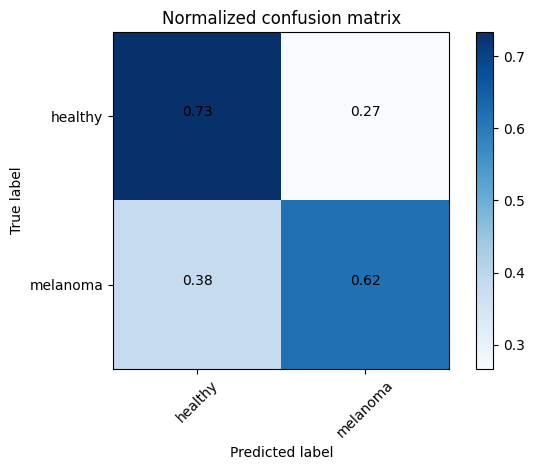

Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.7785714285714287 +- 0.011230929919114991
 Average and std TEST CV accuracy : 0.6833333333333333 +- 0.04298921448873283
 Average and std TRAIN CV f1 : 0.556258107224835 +- 0.014089611130754487
 Average and std TEST CV f1 : 0.37845603780624304 +- 0.047005796979446
Normalized confusion matrix
[[0.73287671 0.26712329]
 [0.52941176 0.47058824]]


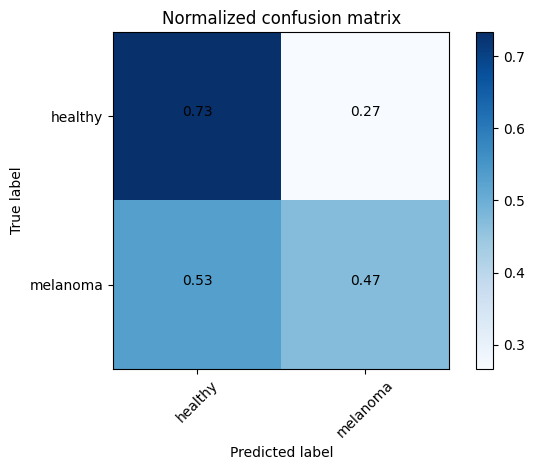

In [98]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline2(ADASYN(random_state=0), StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc, X_train, y_train, cv=5, scoring=(
    'accuracy', 'f1'), return_train_score=True, return_estimator=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(
    Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std()))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(
    Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std()))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(
    Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std()))
print(" Average and std TEST CV f1 : {0} +- {1}".format(
    Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std()))
print()

# Look for the best estimator (the one with the greatest test accuracy)
index_best = np.argmax(Perc_cv['test_accuracy'])
estimator_best = Perc_cv['estimator'][index_best]
y_pred = estimator_best.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

###########################################################

# Fitting linear SVM
print("Fitting Linear SVM")
Lsvm = make_pipeline2(ADASYN(random_state=0), StandardScaler(), LinearSVC())
Lsvm_cv = cross_validate(Lsvm, X_train, y_train, cv=5, scoring=(
    'accuracy', 'f1'), return_train_score=True, return_estimator=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(
    Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std()))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(
    Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std()))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(
    Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std()))
print(" Average and std TEST CV f1 : {0} +- {1}".format(
    Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std()))

# Look for the best estimator (the one with the greatest test accuracy)
index_best = np.argmax(Lsvm_cv['test_accuracy'])
estimator_best = Lsvm_cv['estimator'][index_best]
y_pred = estimator_best.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


Suppose that there are overlapping classes, we need to set the hyper-parameter C for the SVM model. 

**Question** Use Cross-Validation on the oversampled data to find the best C value. Plot the confusion matrix using the best estimator (as before).

**Answers:** The results now seems much better. 

Best training Score: 0.7333333333333334
Best training parameter: 0.01
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       146
           1       0.38      0.56      0.45        34

    accuracy                           0.74       180
   macro avg       0.63      0.67      0.64       180
weighted avg       0.79      0.74      0.76       180

Normalized confusion matrix
[[0.78767123 0.21232877]
 [0.44117647 0.55882353]]


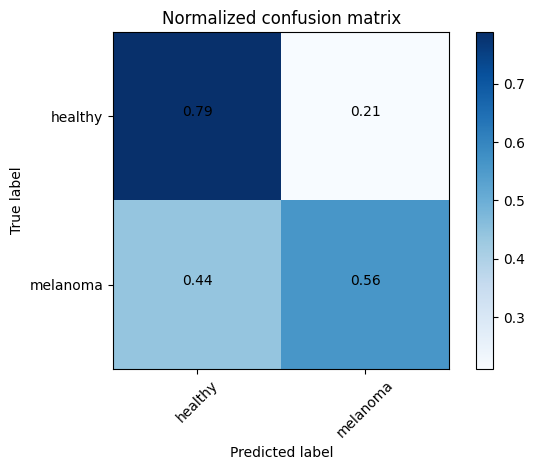

In [99]:
# Looking for the best hyperparameter C 
Lsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), LinearSVC()) 
p_grid_lsvm = {'linearsvc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, scoring="accuracy", cv=5, return_train_score=True)
grid_lsvm.fit(X_train, y_train)

# Look for the best estimator (the one with the greatest test accuracy)
best_estimator = grid_lsvm.best_estimator_
y_pred = best_estimator.predict(X_test)
print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training parameter: {}".format(grid_lsvm.best_params_['linearsvc__C']))


print(classification_report(y_test, y_pred))
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


Here it is the code for non-linear SVM using radial basis function. We need to tune another hyper-parameter $gamma$. We look for the best $C$ and $gamma$ at the same time.

**Question** Use Cross-Validation on the oversampled data to find the best C and $gamma$ value. Plot the confusion matrix using the best estimator (as before).

**Answers:** Now the results are much worse than before, maybe this can be due to overfitting, once we do not have a big ammount of data, or it can be due to the fact that rbf does not capture well the pattern of the data for tha range of hyperpameters chosens.

Fitting Non-linear SVM to the training set...
Best training Score: 0.8071428571428572
Best training parameters: {'svc__C': 0.1, 'svc__gamma': 0.1}
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       146
           1       0.58      0.32      0.42        34

    accuracy                           0.83       180
   macro avg       0.72      0.63      0.66       180
weighted avg       0.80      0.83      0.81       180

Normalized confusion matrix
[[0.94520548 0.05479452]
 [0.67647059 0.32352941]]


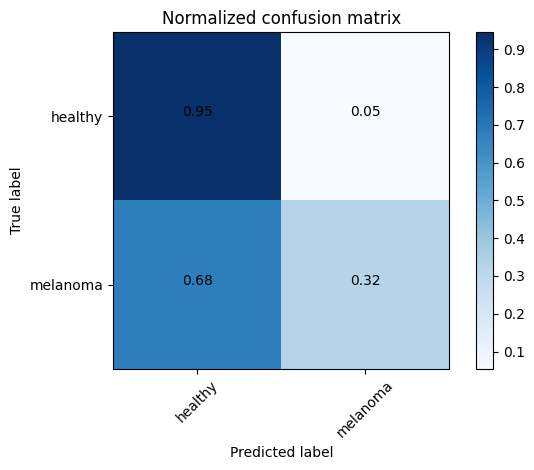

In [100]:
# Fitting Non-linear SVM
print("Fitting Non-linear SVM to the training set...")
NLsvm = make_pipeline2(ADASYN(random_state=0),
                       StandardScaler(), SVC(kernel='rbf'))
p_grid_nlsvm = {'svc__C': [1e-3, 1e-2, 1e-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1e1],
                'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm,
                          scoring='accuracy', cv=5, return_train_score=True)
grid_nlsvm.fit(X_train, y_train)

# Look for the best estimator (the one with the greatest test accuracy)
best_estimator = grid_nlsvm.best_estimator_
y_pred = best_estimator.predict(X_test)
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training parameters: {}".format(grid_nlsvm.best_params_))


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

**Question** Use the non-linear SVM with the two strategies seen before (different scoring function and/or oversampled data). Do the results change ? Why in your opinion ?

**Answer:** Using ```f1``` as score function are considerably better. I believe that because of the chosen metric we can avoid overfitting.

Fitting Non-linear SVM to the training set...
Best training Score: 0.4952054934083175
Best training parameters: {'svc__C': 8, 'svc__gamma': 0.0001}
              precision    recall  f1-score   support

           0       0.89      0.86      0.87       146
           1       0.47      0.56      0.51        34

    accuracy                           0.80       180
   macro avg       0.68      0.71      0.69       180
weighted avg       0.81      0.80      0.81       180

Normalized confusion matrix
[[0.85616438 0.14383562]
 [0.44117647 0.55882353]]


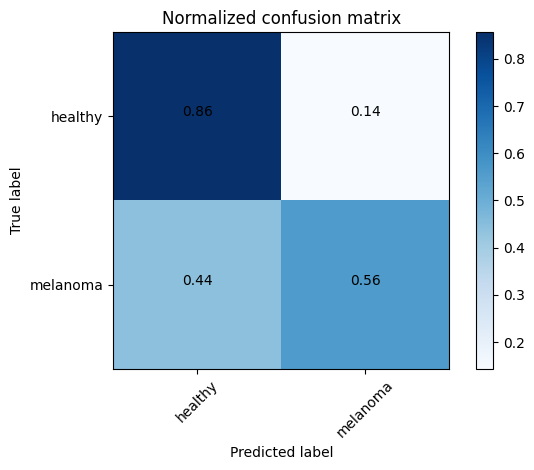

In [101]:
# Fitting Non-linear SVM
print("Fitting Non-linear SVM to the training set...")
NLsvm = make_pipeline2(ADASYN(random_state=0),
                       StandardScaler(), SVC(kernel='rbf'))
p_grid_nlsvm = {'svc__C': [1e-3, 1e-2, 1e-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1e1],
                'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm,
                          scoring='f1', cv=5, return_train_score=True)
grid_nlsvm.fit(X_train, y_train)

# Look for the best estimator (the one with the greatest test accuracy)
best_estimator = grid_nlsvm.best_estimator_
y_pred = best_estimator.predict(X_test)
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training parameters: {}".format(grid_nlsvm.best_params_))


print(classification_report(y_test, y_pred))
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Looking for the best hyperparameter C...
Best training Score: 0.6676470588235295
Best training parameter: 1e-07

              precision    recall  f1-score   support

           0       0.92      0.72      0.81       146
           1       0.38      0.74      0.50        34

    accuracy                           0.72       180
   macro avg       0.65      0.73      0.65       180
weighted avg       0.82      0.72      0.75       180

Normalized confusion matrix
[[0.71917808 0.28082192]
 [0.26470588 0.73529412]]


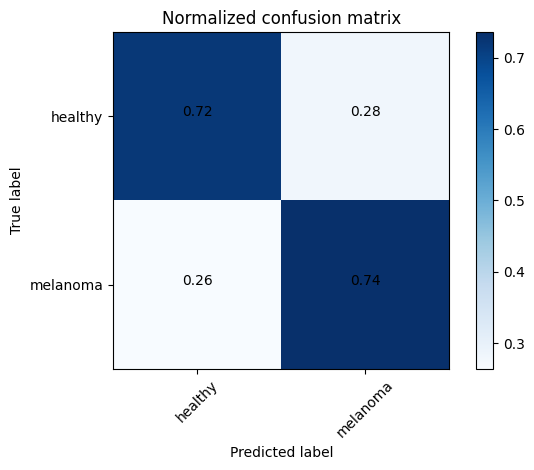

In [79]:
# Looking for the best hyperparameter C
print("Looking for the best hyperparameter C...")
Lsvm = make_pipeline2(ADASYN(random_state=0), StandardScaler(), LinearSVC())
p_grid_lsvm = {'linearsvc__C': [1e-7, 0.5e-6, 1e-6, 0.5e-5, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}
grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm,
                          scoring='f1', cv=5, 
                          return_train_score=True)
grid_lsvm.fit(X_train, y_train)

# Look for the best estimator (the one with the greatest test accuracy)
best_estimator = grid_lsvm.best_estimator_
y_pred = best_estimator.predict(X_test)
print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training parameter: {}".format(grid_lsvm.best_params_['linearsvc__C']))
print()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

**Question** Try to draw a conclusion from the different experiments. Which is the best method ? Which scoring function should you use ? Is it worth it to oversample one of the two classes ?

**Answer:** The best result that I got was with the one seen above, with SVC and f1 as scoring function, using oversampling and scaling.

**OPTIONAL** Another interesting question is: what about the number of features ? Can we reduce the dimensionality ? You could use one of the techniques seen during the previous lectures (i.e. PCA) ...

Using the PCA, we were able to see that the number the half of the features represent 95% of the variability of the data. The results were a little bit worse, but in general it reproduces well the results of the best model.

Fitting SVM with RBF kernel and PCA to the training set...


Best training Score: 0.48372247390075945
Best training parameters:
{'svc__C': 6, 'svc__gamma': 0.0001}
              precision    recall  f1-score   support

           0       0.89      0.84      0.86       146
           1       0.44      0.56      0.49        34

    accuracy                           0.78       180
   macro avg       0.67      0.70      0.68       180
weighted avg       0.81      0.78      0.79       180

Number of features before PCA: 30
Number of principal components retained after PCA: 15
Normalized confusion matrix
[[0.83561644 0.16438356]
 [0.44117647 0.55882353]]


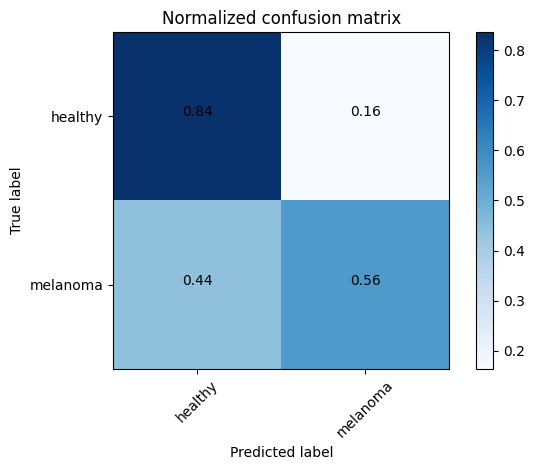

In [78]:

num_features_before = X_train.shape[1]


print("Fitting SVM with RBF kernel and PCA to the training set...")
svm = make_pipeline2(ADASYN(random_state=0), StandardScaler(), PCA(n_components=0.95), SVC(kernel='rbf'))
p_grid_svm = {'svc__C': [1e-3, 1e-2, 1e-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1e1],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
grid_svm = GridSearchCV(estimator=svm, param_grid=p_grid_svm,
                        scoring='f1', cv=5, return_train_score=True)
grid_svm.fit(X_train, y_train)

# Look for the best estimator (the one with the greatest test accuracy)
best_estimator = grid_svm.best_estimator_
y_pred = best_estimator.predict(X_test)
print("Best training Score: {}".format(grid_svm.best_score_))
print("Best training parameters:")
print(grid_svm.best_params_)
print(classification_report(y_test, y_pred))

# 3. After PCA: Get the number of principal components retained
num_components_after = best_estimator.named_steps['pca'].n_components_

# Compare dimensionality
print("Number of features before PCA:", num_features_before)
print("Number of principal components retained after PCA:", num_components_after)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

**OPTIONAL** ... or test the importance of the single features.
The more naive technique would be to test each feature independently in a greedy fashion called sequential forward feature selection. Starting from an empty set and a classification model, you will first add the feature that maximizes a certain criterion (i.e. f1 score). Then, you will iterate this process until a chosen stopping criterion by adding at each iteration only the best feature. Each feature can be added of course only once. You could also use the opposite process by removing at each iteraton the least important feature starting from the entire set of features (i.e. sequential backward feature selection). Implement at least one of these ideas. 